In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import einops
from collections import defaultdict
from typing import Callable, Optional
import os
import importlib
import pickle
import pandas as pd
from typing import List, Dict, Tuple, Optional, Union, Any

import circuits.utils as utils
import circuits.othello_utils as othello_utils
import neuron_simulation.simulation_config as sim_config
import neuron_simulation.simulate_activations_with_dts as sim_activations

/root/OthelloUnderstanding/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
default_config = sim_config.selected_config
device = "cpu"

# If desired, you can run simulate_activations_with_dts.py from this cell
# Values from default config will also be used later on in the notebook to filter out saved pickle files

# Example of filtering out certain configurations

# default_config.n_batches = 2

# for combination in default_config.combinations:
#     combination.ablate_not_selected = [True]

# sim_activations.run_simulations(default_config)

Loading data files...
Loaded 1 ablation files
Loaded 1 mean ablation files
Loaded 1 results files
Sample ablation hyperparameters: {'dataset_size': 600, 'intervention_threshold': 0.7, 'max_depth': 8, 'binary_threshold': 0.1, 'trainer_id': 0, 'input_location': 'mlp_neuron', 'ablation_method': 'dt', 'ablate_not_selected': True, 'add_error': True, 'intervention_layers': [[0], [1], [2], [3], [4], [5], [6], [7]]}
Available metrics in ablation data: ['kl', 'clean_accuracy', 'patch_accuracy']

=== Plotting PATCH_ACCURACY ===
Metric keys: ['mlp_neuron', 'mlp_neuron_mean_ablate']


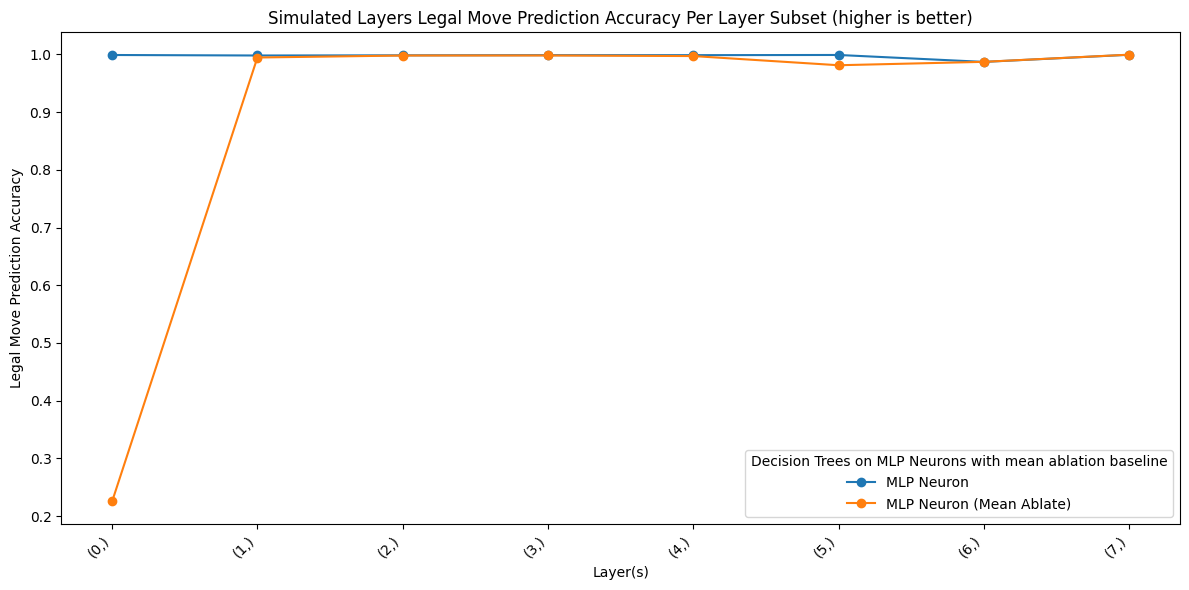


=== Plotting KL ===
Metric keys: ['mlp_neuron', 'mlp_neuron_mean_ablate']


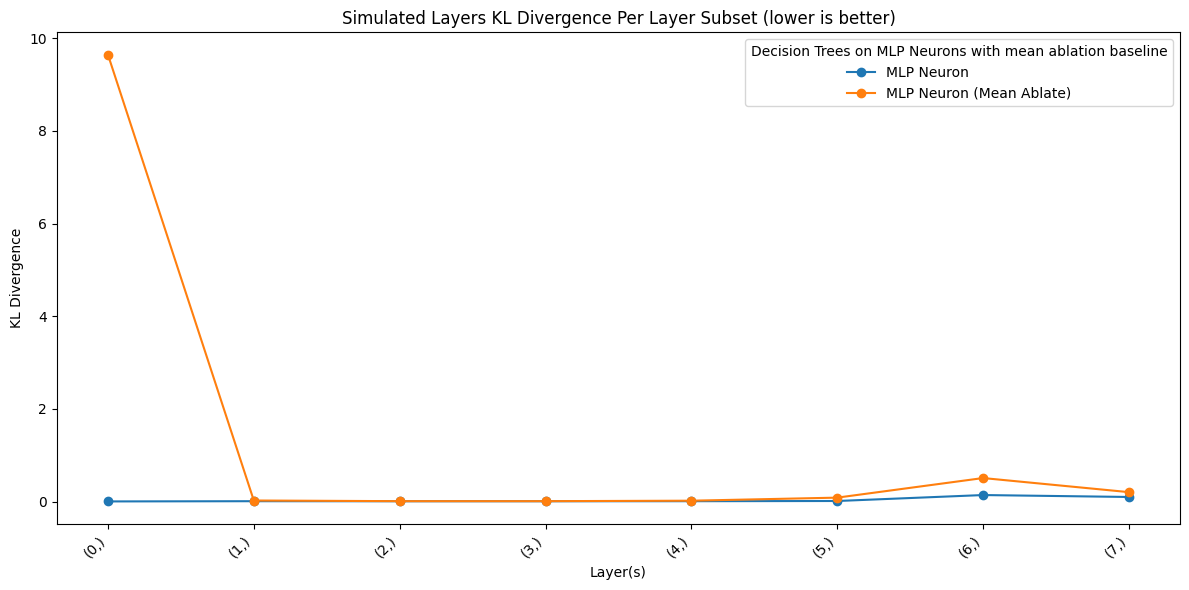


=== Plotting R2 ===
Metric keys: ['mlp_neuron']


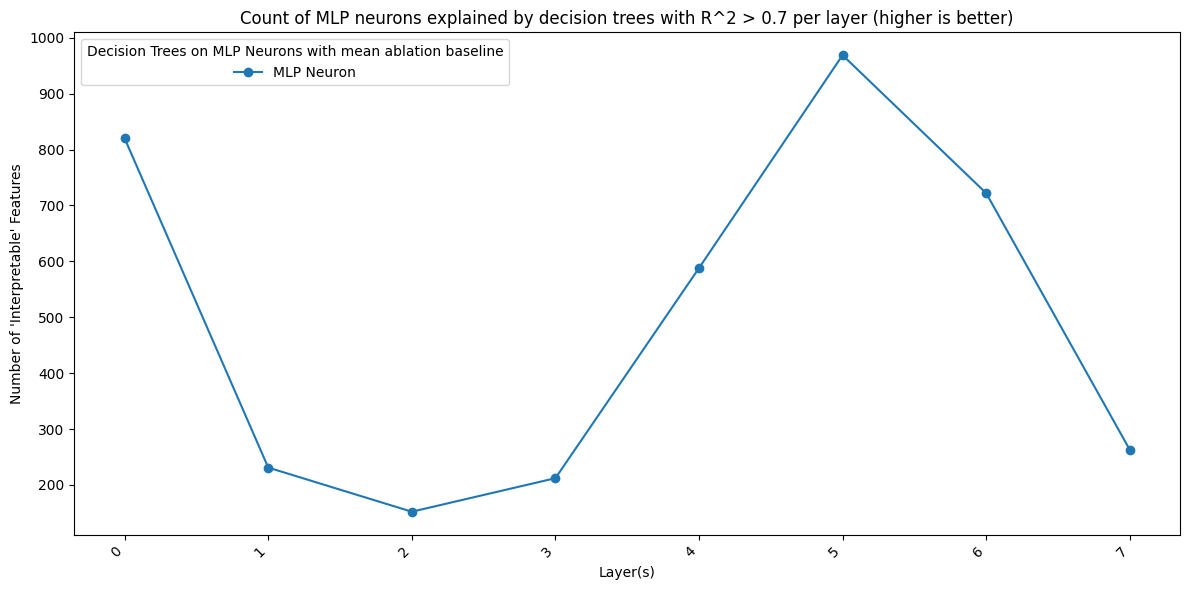


All metrics plotted successfully!


In [4]:
SAE_METRICS = ["kl", "patch_accuracy", "r2"]
GROUP_BY_OPTIONS = ["input_location", "custom_function"]

label_lookup = {
    "mlp_neuron": "MLP Neuron",
    "sae_mlp_out_feature": "SAE Trained on MLP out",
    "transcoder": "Transcoder",
    "mlp_neuron_mean_ablate": "MLP Neuron (Mean Ablate)",
    othello_utils.games_batch_to_input_tokens_flipped_classifier_input_BLC.__name__: "Input Tokens and Flipped Squares",
    othello_utils.games_batch_to_board_state_classifier_input_BLC.__name__: "Board State (Mine / Yours / Blank)",
    othello_utils.games_batch_to_input_tokens_classifier_input_BLC.__name__: "Input Tokens",
}

def load_ablation_pickle_files(
    directory: str,
    dataset_size: int,
    ablation_method: str,
    ablate_not_selected: bool,
    add_error: bool,
):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".pkl") and "ablation" in filename:
            with open(os.path.join(directory, filename), "rb") as f:
                single_data = pickle.load(f)

            hyperparams = single_data["hyperparameters"]
            if hyperparams["ablate_not_selected"] != ablate_not_selected:
                continue

            if hyperparams["input_location"] != "mlp_neuron":
                if hyperparams["add_error"] != add_error:
                    continue

            if hyperparams["ablation_method"] != ablation_method:
                continue

            if hyperparams["dataset_size"] != dataset_size:
                continue
            data.append(single_data)
    return data

def load_results_pickle_files(directory: str, dataset_size: int) -> List[Dict[str, Any]]:
    data = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl') and "ablation" not in filename and "decision_trees" not in filename:
            with open(os.path.join(directory, filename), 'rb') as f:
                single_data = pickle.load(f)

            if single_data['hyperparameters']['dataset_size'] != dataset_size:
                continue
            data.append(single_data)
    return data

def calculate_good_features(results: Dict[str, Any], threshold: float) -> Tuple[int, int]:
    dt_r2 = torch.tensor(results["decision_tree"]["r2"])
    good_dt_r2 = (dt_r2 > threshold).sum()

    # f1 = torch.tensor(results["binary_decision_tree"]["f1"])
    # good_f1 = (f1 > threshold).sum().item()
    good_f1 = -1

    return good_dt_r2, good_f1


def extract_mean_ablation_results(
    data: List[Dict],
    desired_metric: str,
    desired_layer_tuples: Optional[List[Tuple[int]]] = None,
) -> Dict:
    allowed_metrics = ["kl", "patch_accuracy"]
    if desired_metric not in allowed_metrics:
        raise ValueError(f"desired_metric must be one of {allowed_metrics}")

    nested_results = {}
    for run in data:
        hyperparams = run["hyperparameters"]
        input_location = hyperparams["input_location"] + "_mean_ablate"
        trainer_id = hyperparams["trainer_id"]

        nested_results[input_location] = {trainer_id: {}}

        for layer_tuple, func_results in run["results"].items():
            if desired_layer_tuples is not None and layer_tuple not in desired_layer_tuples:
                continue
            prev_result = None
            for idx, func_name in enumerate(func_results):

                result = func_results[func_name][desired_metric]
                nested_results[input_location][trainer_id][layer_tuple] = result

                if idx > 0:
                    assert prev_result == result

                prev_result = result

    return nested_results


def extract_ablation_results(
    data: List[Dict],
    custom_function_names: list[str],
    desired_metric: str,
    group_by: str,
    input_location_filter: Optional[str] = None,
    func_name_filter: Optional[str] = None,
    desired_layer_tuples: Optional[List[Tuple[int]]] = None,
) -> Dict:
    if desired_metric not in SAE_METRICS:
        raise ValueError(f"desired_metric must be one of {SAE_METRICS}")

    if group_by not in GROUP_BY_OPTIONS:
        raise ValueError(f"group_by must be one of {GROUP_BY_OPTIONS}")
    
    if func_name_filter is not None and func_name_filter not in custom_function_names:
        raise ValueError(f"func_name_filter must be one of {custom_function_names}")

    nested_results = {}
    for run in data:
        hyperparams = run["hyperparameters"]
        input_location = hyperparams["input_location"]
        trainer_id = hyperparams["trainer_id"]

        if input_location_filter is not None and input_location != input_location_filter:
            continue

        for custom_function_name in custom_function_names:

            if func_name_filter is not None and custom_function_name != func_name_filter:
                continue

            primary_key = input_location if group_by == "input_location" else custom_function_name

            if primary_key not in nested_results:
                nested_results[primary_key] = {}
            if trainer_id not in nested_results[primary_key]:
                nested_results[primary_key][trainer_id] = {}

            for layer_tuple, func_results in run["results"].items():
                if desired_layer_tuples is not None and layer_tuple not in desired_layer_tuples:
                    continue
                if custom_function_name in func_results:
                    if desired_metric == "r2":
                        good_dt_r2, good_f1 = calculate_good_features(func_results[custom_function_name], 0.7)
                        result = good_dt_r2
                    else:
                        result = func_results[custom_function_name][desired_metric]

                    nested_results[primary_key][trainer_id][layer_tuple] = result

    return nested_results


def min_or_max_metric_per_layer(nested_data, min_or_max: str):
    allowed_options = ["min", "max"]
    if min_or_max not in allowed_options:
        raise ValueError(f"min_or_max must be one of {allowed_options}")

    sorted_metrics = {}
    for input_location, trainer_ids in nested_data.items():
        sorted_metrics[input_location] = {}
        all_layers = set()
        for layer_results in trainer_ids.values():
            all_layers.update(layer_results.keys())

        for layer in all_layers:
            if min_or_max == "min":
                min_kl = float("inf")
            else:
                min_kl = float("-inf")

            for trainer_id, layer_results in trainer_ids.items():
                if layer in layer_results:
                    if min_or_max == "min":
                        min_kl = min(min_kl, layer_results[layer])
                    else:
                        min_kl = max(min_kl, layer_results[layer])
            sorted_metrics[input_location][layer] = min_kl

    return sorted_metrics


def plot_grouped_metrics(nested_metrics: dict, sae_metric: str, group_by: str):

    if sae_metric not in SAE_METRICS:
        raise ValueError(f"sae_metric must be one of {SAE_METRICS}")
    
    if group_by not in GROUP_BY_OPTIONS:
        raise ValueError(f"group_by must be one of {GROUP_BY_OPTIONS}")
    
    if sae_metric == "kl":
        title = "Simulated Layers KL Divergence Per Layer Subset (lower is better)"
        y_label = "KL Divergence"
    elif sae_metric == "patch_accuracy":
        title = "Simulated Layers Legal Move Prediction Accuracy Per Layer Subset (higher is better)"
        y_label = "Legal Move Prediction Accuracy"
    elif sae_metric == "r2":
        title = "Count of MLP neurons explained by decision trees with R^2 > 0.7 per layer (higher is better)"
        y_label = "Number of 'Interpretable' Features"

    if group_by == "input_location":
        legend_title = "Decision Trees on MLP Neurons with mean ablation baseline"
    elif group_by == "custom_function":
        legend_title = "Board to state functions with mean ablation baseline"

    plt.figure(figsize=(12, 6))

    all_layers = set()
    for individual_label, trainer_ids in nested_metrics.items():
        for trainer_id, layer_results in trainer_ids.items():
            all_layers.update(layer_results.keys())

    all_layers = sorted(all_layers)
    layer_labels = [str(layer) for layer in all_layers]

    for individual_label, trainer_ids in nested_metrics.items():

        if individual_label in label_lookup:
            individual_label = label_lookup[individual_label]

        for trainer_id, layer_results in trainer_ids.items():
            values = [layer_results.get(layer, np.nan) for layer in all_layers]
            
            plt.plot(
                range(len(all_layers)),
                values,
                "o-",
                label=f"{individual_label}",
            )

    plt.xlabel("Layer(s)")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title=legend_title)

    plt.xticks(range(len(all_layers)), layer_labels, rotation=45, ha="right")

    plt.tight_layout()
    plt.savefig(f"images/{sae_metric}_{group_by}.png")
    plt.show()


directory = "decision_trees"
# Updated custom function names to match what you trained with
custom_function_names = [
    othello_utils.games_batch_to_input_tokens_flipped_bs_classifier_input_BLC.__name__,
]

default_config = sim_config.selected_config
# Changed from 60 to 600 for the new larger dataset
dataset_size = 600

ablation_method = "dt"
ablate_not_selected = True
add_error = False

desired_layer_tuples = []
# Generate single layer tuples to match your training
for i in range(8):
    desired_layer_tuples.append((i,))

group_by = "input_location"

if group_by == "input_location":
    func_name_filter = custom_function_names[0]
    input_location_filter = None
elif group_by == "custom_function":
    func_name_filter = None
    input_location_filter = "mlp_neuron"  # This matches your training
else:
    raise ValueError(f"Invalid group_by value: {group_by}")

# Load all data sources
print("Loading data files...")
ablation_data = load_ablation_pickle_files(
    directory, dataset_size, ablation_method, ablate_not_selected, add_error
)
mean_ablate_data = load_ablation_pickle_files(directory, dataset_size, "mean", True, True)
results_data = load_results_pickle_files(directory, dataset_size)

print(f"Loaded {len(ablation_data)} ablation files")
print(f"Loaded {len(mean_ablate_data)} mean ablation files") 
print(f"Loaded {len(results_data)} results files")

if ablation_data:
    print("Sample ablation hyperparameters:", ablation_data[0]["hyperparameters"])
    layer_key = list(ablation_data[0]["results"].keys())[0]
    func_key = list(ablation_data[0]["results"][layer_key].keys())[0]
    print("Available metrics in ablation data:", list(ablation_data[0]["results"][layer_key][func_key].keys()))

# Plot all three metrics
metrics_to_plot = ["patch_accuracy", "kl", "r2"]

for desired_metric in metrics_to_plot:
    print(f"\n=== Plotting {desired_metric.upper()} ===")
    
    if desired_metric == "r2":
        # R2 data comes from results files only
        metric_per_layers = extract_ablation_results(
            results_data,
            custom_function_names,
            desired_metric,
            group_by,
            input_location_filter=input_location_filter,
            func_name_filter=func_name_filter,
            desired_layer_tuples=list(range(8)),  # R2 uses single layer indices
        )
        # No mean ablation baseline for R2
    else:
        # KL and patch_accuracy come from ablation files
        metric_per_layers = extract_ablation_results(
            ablation_data,
            custom_function_names,
            desired_metric,
            group_by,
            input_location_filter=input_location_filter,
            func_name_filter=func_name_filter,
            desired_layer_tuples=desired_layer_tuples,
        )
        
        # Add mean ablation baseline
        mean_ablate_per_layers = extract_mean_ablation_results(
            mean_ablate_data, desired_metric, desired_layer_tuples
        )
        for key in mean_ablate_per_layers.keys():
            metric_per_layers[key] = mean_ablate_per_layers[key]

    print("Metric keys:", list(metric_per_layers.keys()))
    
    if metric_per_layers:
        plot_grouped_metrics(metric_per_layers, desired_metric, group_by)
    else:
        print(f"No {desired_metric} data to plot.")

print("\nAll metrics plotted successfully!")

In [4]:
# This cell is disabled since it's specific to SAE evaluations
# For MLP neuron analysis, we don't have L0/fraction recovered metrics

# def graph_3var_results(
#     metric_per_layer: dict,
#     eval_df: pd.DataFrame,
#     layer: int,
#     input_location: str,
#     use_tuple: bool,
#     sae_metric: str,
# ):
#     # Function implementation for SAE-specific 3D plotting
#     pass

print("This cell is disabled for MLP neuron analysis.")
print("The 3D plotting functionality is specific to SAE evaluations with L0/fraction recovered metrics.")
print("For MLP neurons, focus on the main plotting in the previous cell.")

This cell is disabled for MLP neuron analysis.
The 3D plotting functionality is specific to SAE evaluations with L0/fraction recovered metrics.
For MLP neurons, focus on the main plotting in the previous cell.


In [ ]:
# Load and plot R2 results for MLP neurons
dataset_size = 600  # Changed from 60 to 600 for the new larger dataset

# Generate single layer indices for r2 analysis
desired_layer_tuples = list(range(8))

feature_data: List[Dict[str, Any]] = load_results_pickle_files(directory, dataset_size=dataset_size)
print(f"Loaded {len(feature_data)} feature files")

if feature_data:
    print("Sample feature data hyperparameters:", feature_data[0]["hyperparameters"])

good_features_per_layer = extract_ablation_results(
    feature_data,
    custom_function_names,
    "r2",
    group_by="input_location",
    input_location_filter="mlp_neuron",  # Filter for MLP neurons only
    func_name_filter=func_name_filter,
    desired_layer_tuples=desired_layer_tuples,
)

print("R2 features per layer keys:", good_features_per_layer.keys())

if good_features_per_layer:
    plot_grouped_metrics(good_features_per_layer, "r2", group_by="input_location")
else:
    print("No R2 data to plot. Check if your result pickle files exist.")

In [6]:
# This cell is disabled since it's specific to SAE evaluations
print("This cell is disabled for MLP neuron analysis.")
print("It was designed for SAE-specific 3D plotting with L0/fraction recovered metrics.")
print("For MLP neuron analysis, use the main plotting functionality in the previous cells.")

This cell is disabled for MLP neuron analysis.
It was designed for SAE-specific 3D plotting with L0/fraction recovered metrics.
For MLP neuron analysis, use the main plotting functionality in the previous cells.


In [ ]:
# Currently broken, just need to get the dictionary keys right
# This can be used to plot multiple thresholds for a single location / custom function combination

# colors = ['b', 'g', 'r']  # Colors for different thresholds
# markers = ['o', 's', '^']  # Markers for different thresholds

# for custom_function in custom_functions:
#     function_name = custom_function.__name__
    
#     plt.figure(figsize=(12, 7))
    
#     for i, threshold in enumerate(thresholds):
#         f1_counts = accuracy_by_layer[function_name][threshold]
        
#         plt.plot(intervention_layers, f1_counts, color=colors[i], marker=markers[i], 
#                  label=f'Threshold: {threshold}', linewidth=2, markersize=8)
        
#         # Optionally, add value labels on each point
#         for j, count in enumerate(f1_counts):
#             plt.annotate(str(count), (intervention_layers[j], count), 
#                          textcoords="offset points", xytext=(0,5), ha='center', 
#                          fontsize=8, color=colors[i])
    
#     plt.title(f'Number of Neurons with F1 > Threshold for \n{function_labels[custom_function]} by Layer \n{dataset_size} datapoints Input location: {input_location} depth: {max_depth}', fontsize=14)
#     plt.xlabel('Layer Number', fontsize=12)
#     plt.ylabel('F1 Count', fontsize=12)
#     plt.legend(loc='best', fontsize=10)
#     plt.grid(True, linestyle='--', alpha=0.7)
    
#     plt.tight_layout()
#     output_filename = f"images/{input_location}_{function_name}_inputs_{dataset_size}_depth_{max_depth}_f1_count_by_layer_all_thresholds.png"
#     plt.savefig(output_filename, dpi=300, bbox_inches='tight')
#     plt.show()

# print("All graphs have been created and saved.")

In [ ]:
# Currently broken, just need to get the dictionary keys right

# layer = 1
# neuron_idx = 421
# custom_function_name = custom_functions[0].__name__

# decision_tree_filename = f"decision_trees/decision_trees_{input_location}_{dataset_size}.pkl"

# with open(decision_tree_filename, "rb") as f:
#     decision_tree = pickle.load(f)

# layer_dt = decision_tree[layer][custom_function_name]['decision_tree']['model']
# layer_dt = decision_tree[layer][custom_function_name]['binary_decision_tree']['model']

# games_BLC = train_data[custom_function_name]

# feature_names = []

# X_binary_train, X_binary_test, y_binary_train, y_binary_test = prepare_data(
#     games_BLC, binary_acts[layer]
# )
# accuracy, precision, recall, f1 = calculate_binary_metrics(
#     decision_tree[layer][custom_function_name]["binary_decision_tree"]["model"], X_binary_test, y_binary_test
# )

# print(f"Neuron 421 F1: {f1[neuron_idx]}")

# for i in range(games_BLC.shape[2]):
#     if i < 64:
#         square = idx_to_square_notation(i)
#         feature_names.append(f"Input_{square}")
#     elif i < 128:
#         j = i - 64
#         square = idx_to_square_notation(j)
#         feature_names.append(f"Occupied_{square}")
#     else:
#         feature_names.append(f"Output_{i}")

# print_decision_tree_rules(layer_dt, feature_names=feature_names, neuron_index=neuron_idx, max_depth=5)



In [5]:
# Print results in the same format as simulate_activations_with_dts.py console output

def print_console_style_results():
    """Print results exactly as they appear in the console when running simulate_activations_with_dts.py"""
    
    print("=== CONSOLE-STYLE RESULTS OUTPUT ===\n")
    
    # Load all data
    ablation_data = load_ablation_pickle_files(directory, dataset_size, "dt", True, False)
    mean_ablate_data = load_ablation_pickle_files(directory, dataset_size, "mean", True, True) 
    results_data = load_results_pickle_files(directory, dataset_size)
    
    # Print decision tree ablation results
    if ablation_data:
        for data_entry in ablation_data:
            hyperparams = data_entry["hyperparameters"]
            results = data_entry["results"]
            
            ablation_method = hyperparams["ablation_method"]
            ablate_not_selected = hyperparams["ablate_not_selected"]
            add_error = hyperparams["add_error"]
            input_location = hyperparams["input_location"]
            
            # Get custom function name from results
            layer_key = list(results.keys())[0]
            custom_function_name = list(results[layer_key].keys())[0]
            
            print(f"ablation_method: {ablation_method}, ablate_not_selected: {ablate_not_selected}, add_error: {add_error}")
            print(f"selected_layers: {list(hyperparams['intervention_layers'])}, input_location: {input_location}, custom_function: {custom_function_name}")
            
            # Get metrics for each layer - print all layers, not just first one
            for layer_tuple, layer_results in sorted(results.items()):
                func_results = layer_results[custom_function_name]
                kl_div = func_results["kl"].item()
                clean_accuracy = func_results["clean_accuracy"].item()
                patch_accuracy = func_results["patch_accuracy"].item()
                
                print(f"Layer {layer_tuple[0]} - {kl_div:.4f} Mean KL div (lower is better)")
                print(f"Layer {layer_tuple[0]} - {clean_accuracy:.4f} Original model legal move accuracy (should be ~0.9998)")
                print(f"Layer {layer_tuple[0]} - {patch_accuracy:.4f} Patch intervention (higher is better)")
                print()  # Empty line between layers
            
            print()  # Empty line between entries
    
    # Print mean ablation baseline results
    if mean_ablate_data:
        for data_entry in mean_ablate_data:
            hyperparams = data_entry["hyperparameters"]
            results = data_entry["results"]
            
            ablation_method = hyperparams["ablation_method"] 
            ablate_not_selected = hyperparams["ablate_not_selected"]
            add_error = hyperparams["add_error"]
            input_location = hyperparams["input_location"]
            
            # Get custom function name from results
            layer_key = list(results.keys())[0]
            custom_function_name = list(results[layer_key].keys())[0]
            
            print(f"ablation_method: {ablation_method}, ablate_not_selected: {ablate_not_selected}, add_error: {add_error}")
            print(f"selected_layers: {list(hyperparams['intervention_layers'])}, input_location: {input_location}, custom_function: {custom_function_name}")
            
            # Get metrics for each layer - print all layers, not just first one
            for layer_tuple, layer_results in sorted(results.items()):
                func_results = layer_results[custom_function_name]
                kl_div = func_results["kl"].item()
                clean_accuracy = func_results["clean_accuracy"].item() 
                patch_accuracy = func_results["patch_accuracy"].item()
                
                print(f"Layer {layer_tuple[0]} - {kl_div:.4f} Mean KL div (lower is better)")
                print(f"Layer {layer_tuple[0]} - {clean_accuracy:.4f} Original model legal move accuracy (should be ~0.9998)")
                print(f"Layer {layer_tuple[0]} - {patch_accuracy:.4f} Patch intervention (higher is better)")
                print()  # Empty line between layers
            
            print()  # Empty line between entries
    
    # Print decision tree feature counts (R² results)
    if results_data:
        print("=== DECISION TREE FEATURE ANALYSIS ===")
        for data_entry in results_data:
            hyperparams = data_entry["hyperparameters"]
            results = data_entry["results"]
            
            input_location = hyperparams["input_location"]
            custom_function_name = list(results[0].keys())[0]  # Results use integer keys
            
            print(f"input_location: {input_location}, custom_function: {custom_function_name}")
            
            for layer in range(8):  # Assuming 8 layers
                if layer in results:
                    layer_results = results[layer][custom_function_name]
                    dt_r2 = torch.tensor(layer_results["decision_tree"]["r2"])
                    total_neurons = dt_r2.shape[0]
                    good_neurons = (dt_r2 > 0.7).sum().item()
                    
                    print(f"Layer {layer}: Out of {total_neurons} neurons, {good_neurons} can be fit well by a decision tree")
            
            print()  # Empty line

# Run the console-style output
print_console_style_results()

=== CONSOLE-STYLE RESULTS OUTPUT ===

ablation_method: dt, ablate_not_selected: True, add_error: True
selected_layers: [[0], [1], [2], [3], [4], [5], [6], [7]], input_location: mlp_neuron, custom_function: games_batch_to_input_tokens_flipped_bs_classifier_input_BLC
Layer 0 - 0.0165 Mean KL div (lower is better)
Layer 0 - 0.9996 Original model legal move accuracy (should be ~0.9998)
Layer 0 - 0.9967 Patch intervention (higher is better)

Layer 1 - 0.0112 Mean KL div (lower is better)
Layer 1 - 0.9996 Original model legal move accuracy (should be ~0.9998)
Layer 1 - 0.9980 Patch intervention (higher is better)

Layer 2 - 0.0069 Mean KL div (lower is better)
Layer 2 - 0.9996 Original model legal move accuracy (should be ~0.9998)
Layer 2 - 0.9988 Patch intervention (higher is better)

Layer 3 - 0.0089 Mean KL div (lower is better)
Layer 3 - 0.9996 Original model legal move accuracy (should be ~0.9998)
Layer 3 - 0.9986 Patch intervention (higher is better)

Layer 4 - 0.0169 Mean KL div (lowe